# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

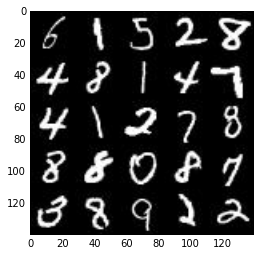

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

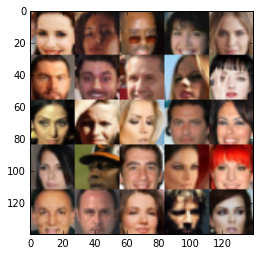

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    training = is_train
    alpha = 0.1
    output_dim = out_channel_dim
    #reuse = False
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.75)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.75)
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 50
    losses = []
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2.0 
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 27.7701
Epoch 1/2... Discriminator Loss: 0.0225... Generator Loss: 17.2554
Epoch 1/2... Discriminator Loss: 0.3742... Generator Loss: 8.3138
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 3.3480
Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 6.5395


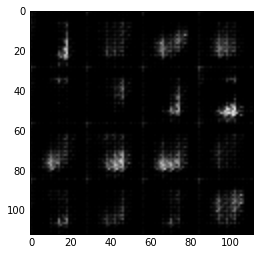

Epoch 1/2... Discriminator Loss: 0.4409... Generator Loss: 1.9900
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.6148
Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 3.8037


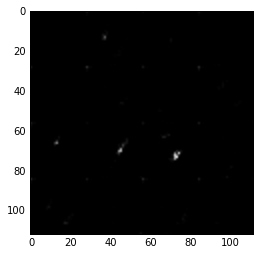

Epoch 1/2... Discriminator Loss: 0.6710... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 0.6741... Generator Loss: 1.7329
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 1.4784
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.1219


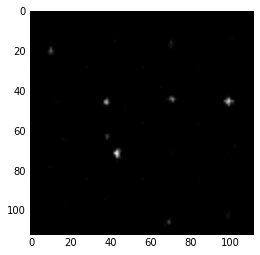

Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.5147


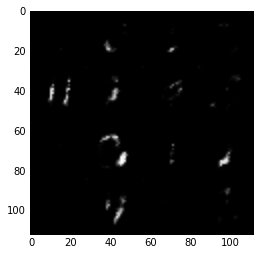

Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 0.9132
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.2334


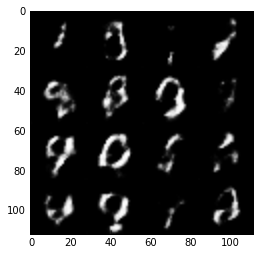

Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 1.3834
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 2.1000
Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 1.1518


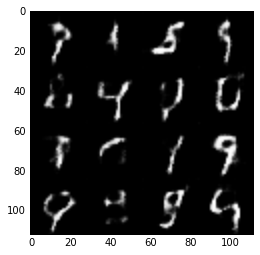

Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.9119
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.4288
Epoch 1/2... Discriminator Loss: 1.0400... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.3801... Generator Loss: 0.4626


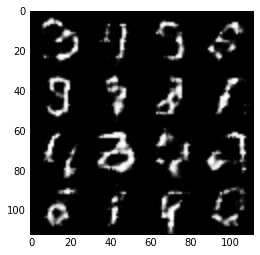

Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.2846


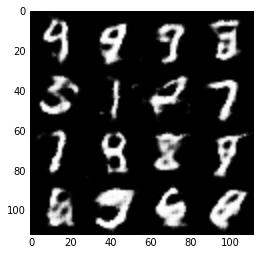

Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 1.8690
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6423
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.3954
Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 1.3427


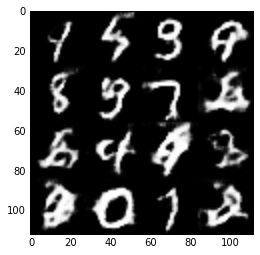

Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 1.3417
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2427
Epoch 2/2... Discriminator Loss: 1.7030... Generator Loss: 2.4357
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.8598


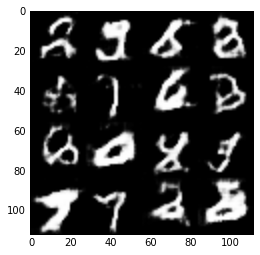

Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.3127
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 1.5333
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 1.1842
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.8417


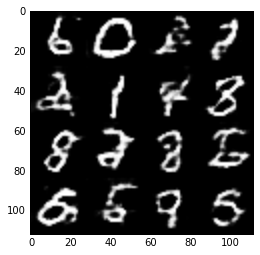

Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.0661
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.3590


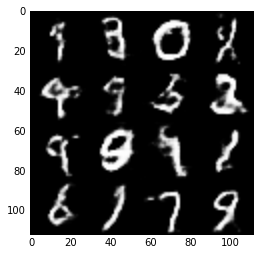

Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 1.0699
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 1.3872
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.4198
Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.2119


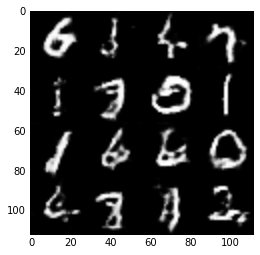

Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 1.6272
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 2.2367... Generator Loss: 0.1889
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.2612


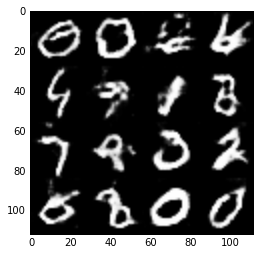

Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 1.2754
Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 0.8185
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 1.3125


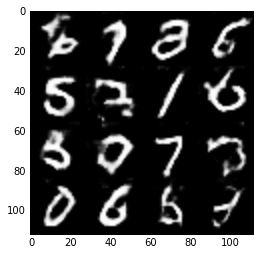

Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.7703
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.6737
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.2198
Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.0596


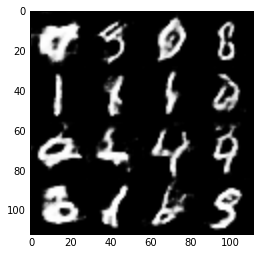

Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 2.3455
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.9299


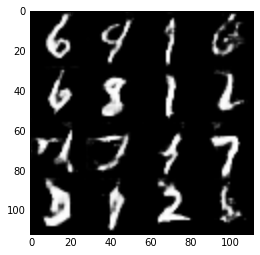

Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.5345
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.5036
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 0.8904
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 0.7860


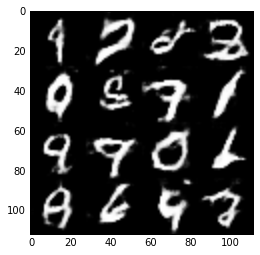

Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.4914
Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.0076
Epoch 2/2... Discriminator Loss: 1.0117... Generator Loss: 0.7868


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.2951
Epoch 1/1... Discriminator Loss: 0.1948... Generator Loss: 14.3070
Epoch 1/1... Discriminator Loss: 1.6850... Generator Loss: 0.3712
Epoch 1/1... Discriminator Loss: 3.1498... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.1356... Generator Loss: 0.1915


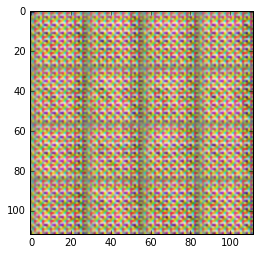

Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 1.7659... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 0.8831


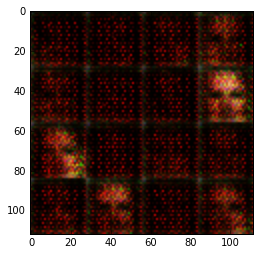

Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 1.3852
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 2.4543
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 2.5882
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 2.9136
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 5.9318


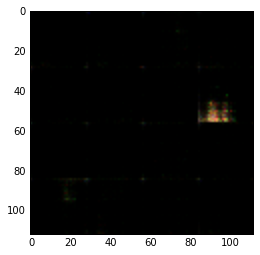

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 0.3405... Generator Loss: 2.9843
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 2.7775
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 1.9259


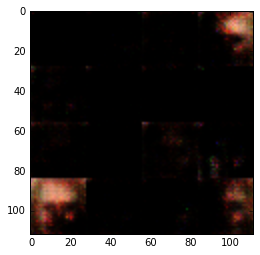

Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.6627
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.0363


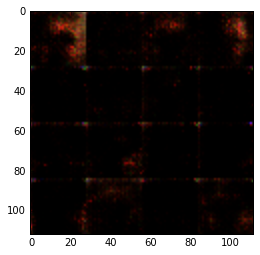

Epoch 1/1... Discriminator Loss: 1.7490... Generator Loss: 4.3035
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 2.3549... Generator Loss: 3.8403
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.7875


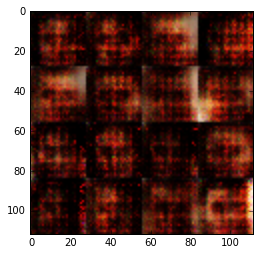

Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 3.1091
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 3.4474


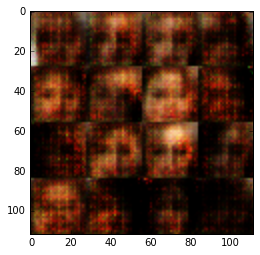

Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.8744
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.5419
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 2.6322
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.6900
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.3235


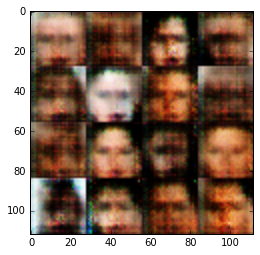

Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.3043


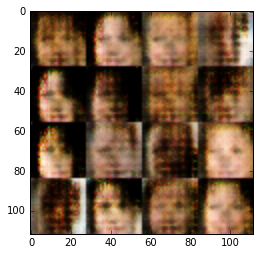

Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.6817


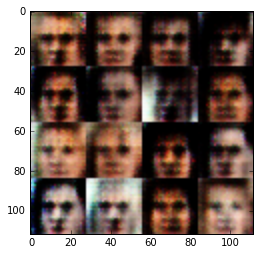

Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 3.1952
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.3366


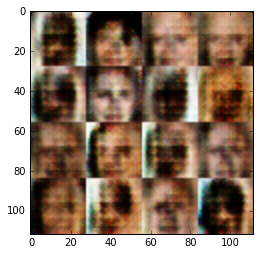

Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.4820
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 2.2822
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.1942


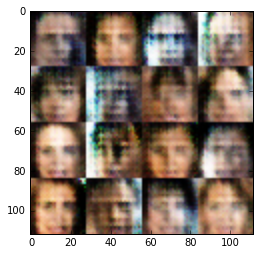

Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.5107
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.4276


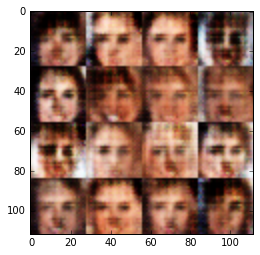

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.7449


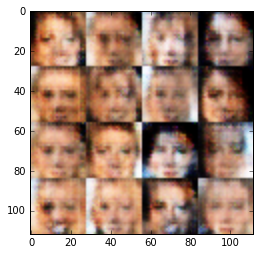

Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 2.1608
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.3483


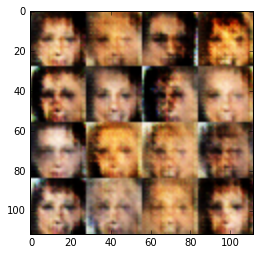

Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.2009


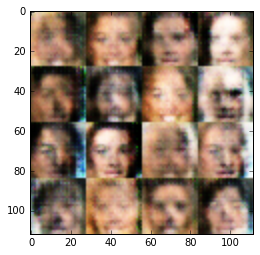

Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 2.3088
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.6912


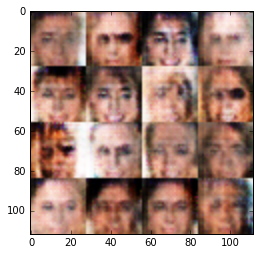

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.9626
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 2.9350
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.2631


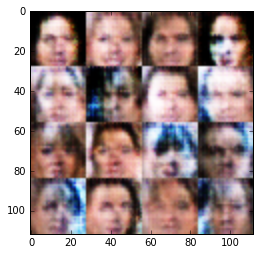

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7197


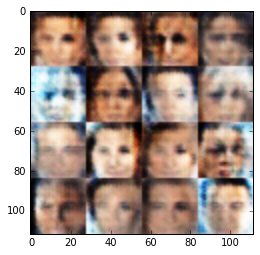

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.3934
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.1824


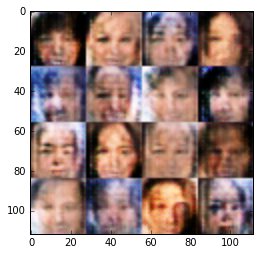

Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 2.1897
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.3282
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.7216


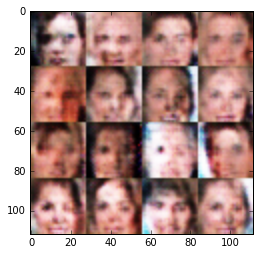

Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 2.4883
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.2471


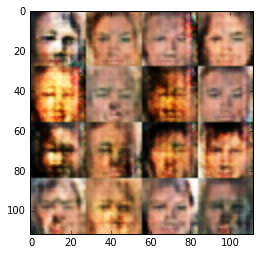

Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 2.7556
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.6977


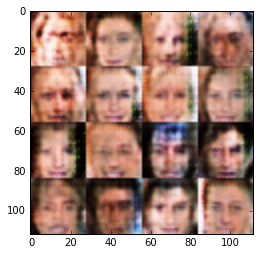

Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.7017


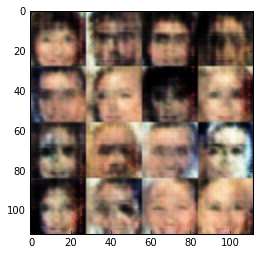

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 0.8903... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.0459


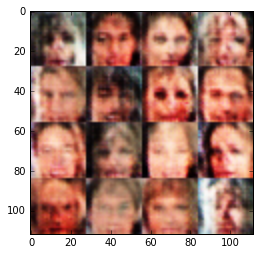

Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5969


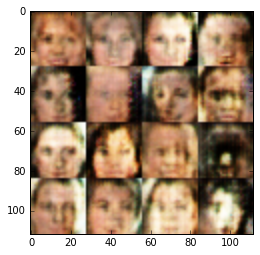

Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.1685


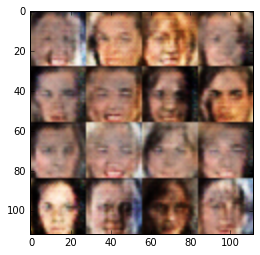

Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.4510
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.9444


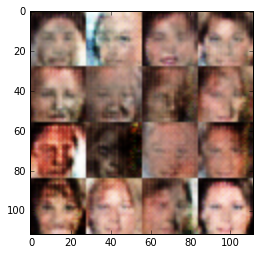

Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.9048


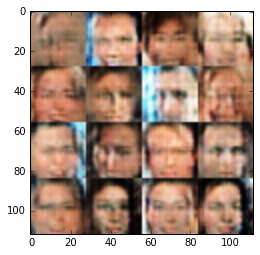

Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.2003


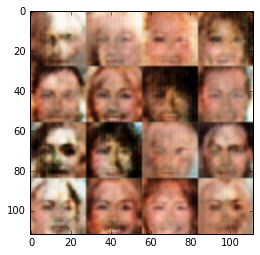

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.